## Problem Definition

In [2]:
TRAIN_POLICY: bool=True
SEED=42
N_TASKS=3
RANDOM_SEED=42

from garage.experiment.deterministic import set_seed
from garage.envs.point_env import PointEnv
from src.learning.inference.utils import sample_traj_of_env, sample_meta_traj
from src.plotting.rl.circle import plot_rollouts_on_circle
from src.utils import GarageToGymWrapper

from constants import FIG_HEIGHT, DPI, LABEL_FONT_SIZE

set_seed(SEED)
CircleRotation=PointEnv()
train_goal_locations=CircleRotation.sample_tasks(N_TASKS)

task_0=PointEnv()
task_0.set_task(train_goal_locations[0])

task_1=PointEnv()
task_1.set_task(train_goal_locations[1])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [3]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env

# Training setup
N_ENVS=1 #does not learn for more envs as environment too simple!
N_STEPS=150_000

def train_and_save_policy(task_env, 
                          task_name,
                          seed:int=RANDOM_SEED,
                          n_envs:int=N_ENVS,
                          N_steps:int=150_000):
    """Trains a policy in a Garage task_env via SAC and saves the policy and the replay buffer."""
    task_0_gym=GarageToGymWrapper(task_env=task_env)

    vec_env = make_vec_env(lambda: task_0_gym, n_envs=n_envs, seed=seed)
    pi = SAC("MlpPolicy", vec_env, verbose=1, seed=seed, batch_size=128)
    pi.learn(total_timesteps=N_steps)
    
    pi.save(task_name)
    pi.save_replay_buffer(task_name+ "_replay_buffer")

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -103     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 118      |
|    time_elapsed    | 3        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | -1.69    |
|    critic_loss     | 0.0272   |
|    ent_coef        | 0.915    |
|    ent_coef_loss   | -0.299   |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.8     |
|    ep_rew_mean     | -84.4    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 103      |
|    time_elapsed    | 7        |
|    total_timesteps | 742      |
| train/             |          |
|    actor_loss      | -2.14    |
|    critic_loss     | 0.0909  

## Evaluate policy

In [4]:
# Evaluate policy

N_TEST_TASKS: int=20
test_tasks = CircleRotation.sample_tasks(N_TEST_TASKS, mode="linspace")
test_tasks_flat = [d['goal'] for d in test_tasks]
train_tasks_flat = [train_goal_locations[0]["goal"]]

test_envs = [PointEnv() for _ in range(N_TEST_TASKS)]
for env, task in zip(test_envs, test_tasks):
    env.set_task(task)
test_envs = [GarageToGymWrapper(task_env=env) for env in test_envs]
train_envs=[task_0_gym]

train_pis=[policy_base for _ in range(len(train_envs))]
test_pis=[policy_base for _ in range(len(test_envs))]

rollouts=sample_meta_traj(train_envs=train_envs, 
                          test_envs=test_envs,
                          train_pis=train_pis,
                          test_pis=test_pis)

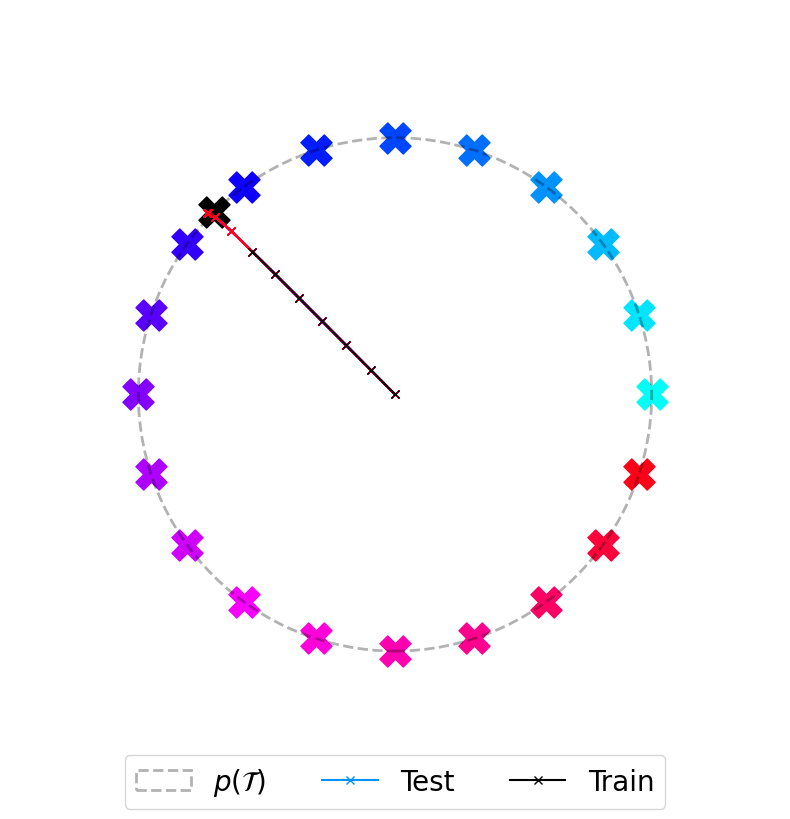

In [5]:
plot_rollouts_on_circle(train_trajectories=rollouts["train"]["states"],
                        # test_trajectories=[],
                        # test_goal_locations=[],
                        test_trajectories=rollouts["test"]["states"],
                        train_goal_locations=train_tasks_flat,
                        test_goal_locations=test_tasks_flat,
                        fig_height=FIG_HEIGHT, label_font_size=LABEL_FONT_SIZE, dpi=DPI,
                        legend=True,
                        savepath=None
                        # savepath="circle_nav_vanilla_meta_rl"
                        )

## Geometric Meta-RL

In [6]:
import warnings
from typing import Callable, Optional

import numpy as np

warnings.warn("Currently only setup for one base task.")

class GeometricPolicy:
    """Performs a geometric update of a base policy given a Lie group generator and a theta."""
    warnings.warn("TODO: Update to generator using matrix exponential.")
    warnings.warn("TODO: Update to include action transformations.")
    def __init__(self, 
                 base_pi,
                 l_g: Optional[Callable] = None,
                 encoder_s: Optional[Callable] = None,
                 h_g: Optional[Callable] = None,
                 decoder_a: Optional[Callable] = None):
        """
        TODO
        """
        self.base_pi = base_pi
        self.l_g = l_g if l_g is not None else lambda s: s
        self.encoder_s = encoder_s if encoder_s is not None else lambda s: s
        self.h_g = h_g if h_g is not None else lambda a: a
        self.decoder_a = decoder_a if decoder_a is not None else lambda a: a
    

    def predict(self, obs, deterministic=True):

        """
        TODO
        """
        # 1. Encode into new basis
        s_tilde=self.encoder_s(obs)

        # 2. Act on state
        s_transformed = self.l_g(s_tilde)

        # 2. Call base policy
        # Add dummy second output to mirror garage policy interface.
        a_tilde, _ = self.base_pi.predict(s_transformed, deterministic=deterministic)

        # 3. Update left-action of policy
        a_transformed_tilde = self.h_g(a_tilde)

        # 4. Return action in original basis
        return self.decoder_a(a_transformed_tilde), _

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_11638/3250384822.py:6: UserWarning: Currently only setup for one base task.
  warnings.warn("Currently only setup for one base task.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_11638/3250384822.py:10: UserWarning: TODO: Update to generator using matrix exponential.
  warnings.warn("TODO: Update to generator using matrix exponential.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_11638/3250384822.py:11: UserWarning: TODO: Update to include action transformations.
  warnings.warn("TODO: Update to include action transformations.")


In [7]:
# Calculate rotation angle of goal location
rot_angle_from_goal = lambda goal_location: np.arctan2(goal_location[1], goal_location[0])
train_tasks_rotations= [rot_angle_from_goal(goal_location) for goal_location in train_tasks_flat]
test_tasks_rotations = [rot_angle_from_goal(goal_location) for goal_location in test_tasks_flat]
base_rotation_task=train_tasks_rotations[0]

### Hereditary Geometry

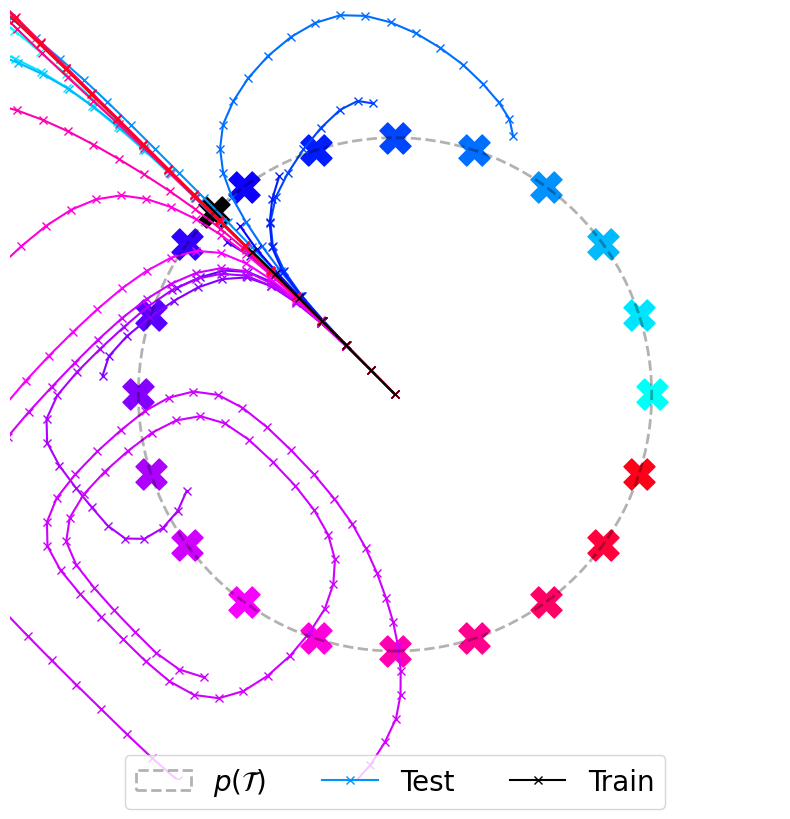

In [8]:
LG = lambda theta : np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

encoder_S_train=[lambda s: s for _ in train_tasks_rotations]
decoder_A_train=[lambda a: a for _ in train_tasks_rotations]
l_g_train = [lambda s, theta=theta: LG(theta - base_rotation_task) @ s for theta in train_tasks_rotations]
h_g_train = [lambda a: a for _ in train_tasks_rotations]

train_geo_pis = [GeometricPolicy(base_pi=policy_base, l_g=l_g, encoder_s=None, h_g=None, decoder_a=None) for l_g in l_g_train]

encoder_S_test=[lambda s: s for _ in test_tasks_rotations]
decoder_A_test=[lambda a: a for _ in test_tasks_rotations]
l_g_test = [lambda s, theta=theta: LG(theta - base_rotation_task) @ s for theta in test_tasks_rotations]
h_g_test = [lambda a: a for _ in test_tasks_rotations]

test_geo_pis = [GeometricPolicy(base_pi=policy_base, l_g=l_g, encoder_s=None, h_g=None, decoder_a=None) for l_g in l_g_test]


geo_rollouts=sample_meta_traj(train_envs=train_envs, 
                          test_envs=test_envs,
                          train_pis=train_geo_pis,
                          test_pis=test_geo_pis)

plot_rollouts_on_circle(train_trajectories=geo_rollouts["train"]["states"],
                        test_trajectories=geo_rollouts["test"]["states"],
                        train_goal_locations=train_tasks_flat,
                        test_goal_locations=test_tasks_flat,
                        fig_height=FIG_HEIGHT, label_font_size=LABEL_FONT_SIZE, dpi=DPI,
                        legend=True,
                        savepath=None
                        # savepath="circle_nav_vanilla_meta_rl"
                        )

### Hereditary Symmetry

In [ ]:
H = lambda s: s-(1,0)
H_inv = lambda s: s+(1,0)

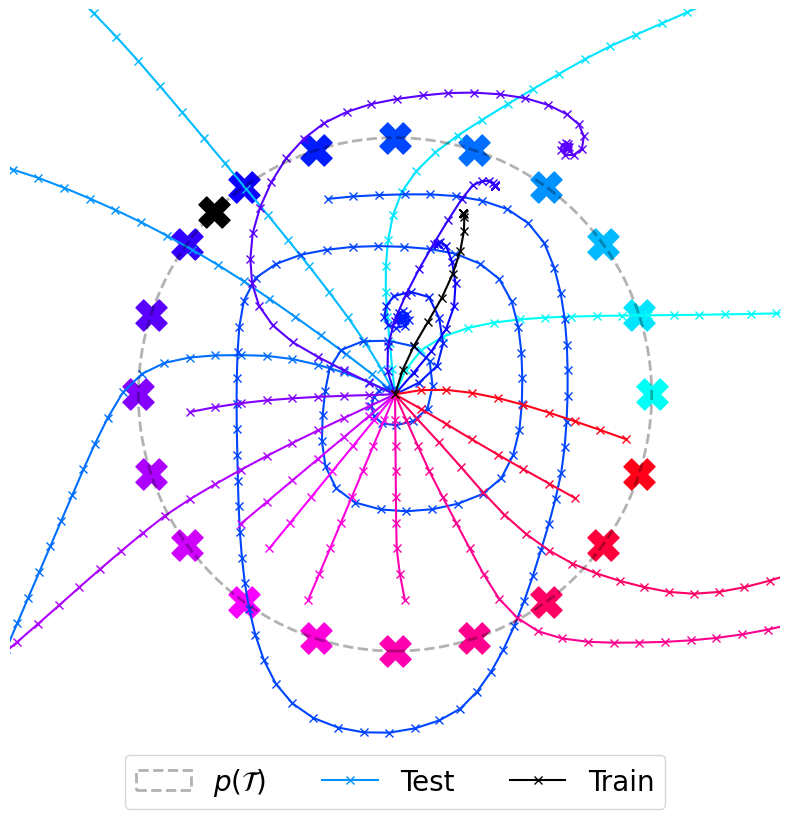

In [9]:
HG = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

encoder_S_train=[lambda s: s-(1,0) for _ in train_tasks_rotations]
decoder_A_train=[None for _ in train_tasks_rotations]
l_g_train = [None for _ in train_tasks_rotations]
h_g_train = [lambda a, theta=theta: HG(theta - base_rotation_task) @ a for theta in train_tasks_rotations]

train_sym_pis = [GeometricPolicy(base_pi=policy_base, l_g=l_g, encoder_s=encoder_s, h_g=h_g, decoder_a=decoder_a) for l_g, encoder_s, h_g, decoder_a in zip(h_g_train, encoder_S_train, h_g_train, decoder_A_train)]

encoder_S_test=[lambda s: s-(1,0) for _ in test_tasks_rotations]
decoder_A_test=[None for _ in test_tasks_rotations]
l_g_test = [None for _ in test_tasks_rotations]
h_g_test = [lambda a, theta=theta: HG(theta - base_rotation_task) @ a for theta in test_tasks_rotations]

test_sym_pis = [GeometricPolicy(base_pi=policy_base, l_g=l_g, encoder_s=encoder_s, h_g=h_g, decoder_a=decoder_a) for l_g, encoder_s, h_g, decoder_a in zip(h_g_test, encoder_S_test, h_g_test, decoder_A_test)]

# Rollout policies
geo_rollouts=sample_meta_traj(train_envs=train_envs, 
                          test_envs=test_envs,
                          train_pis=train_sym_pis,
                          test_pis=test_sym_pis)

# Plot rollouts
plot_rollouts_on_circle(train_trajectories=geo_rollouts["train"]["states"],
                        test_trajectories=geo_rollouts["test"]["states"],
                        train_goal_locations=train_tasks_flat,
                        test_goal_locations=test_tasks_flat,
                        fig_height=FIG_HEIGHT, label_font_size=LABEL_FONT_SIZE, dpi=DPI,
                        legend=True,
                        savepath=None
                        # savepath="circle_nav_vanilla_meta_rl"
                        )